# CP decomposition for neural data

## Content
1. **Import and utils**
2. **Implementation**
    - TensorLy
    - tensortools
    - Numpy
3. **Reconstruction error and time comparison**

---

## Imports and utils

In [ ]:
%pip install tensorly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
%pip install tensortools

  Preparing metadata (setup.py) ... done
  Created wheel for tensortools: filename=tensortools-0.4-py3-none-any.whl size=50737 sha256=c3758c9173a59cbdff4f1501bcf7d9a902a277d569107d7f19fa7666f4339fa7
  Stored in directory: /root/.cache/pip/wheels/aa/c2/2e/bb743e48ad6aca7963fe25cb4723b27cff2943bd7400aeaa84
Successfully built tensortools


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def rank_one_tensor(a, b, c):
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    return np.tensordot(a * b.T, c, axes=0)[:, :, :, 0]


def normalize(x, lower=0, upper=1, axis=0):
    return (x - x.min(axis=axis)) / (x.max(axis=axis) - x.min(axis=axis))


def reconstruct(factors, rank=None):
    a, b, c = factors
    rank = rank if rank else a.shape[1]
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i])
    return R1s.sum(axis=3)

def plot_factors(factors, d=3):
    a, b, c = factors
    rank = a.shape[1]
    fig, axes = plt.subplots(rank, d, figsize=(8, int(rank * 1.2 + 1)))
    factors_name = ["Time", "Features", "Time"] if d==3 else ["Time", "Features"]
    for ind, (factor, axs) in enumerate(zip(factors[:d], axes.T)):
        axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            ax.plot(f)
            axes[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()


def compare_factors(factors, factors_actual, factors_ind=[0, 1, 2], fig=None):

    a_actual, b_actual, c_actual = factors_actual
    a, b, c = factors
    rank = a.shape[1]

    fig, axes = fig, np.array(fig.axes).reshape(rank, -1) if fig else plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
    sns.despine(top=True)

    f_ind = factors_ind

    for ind, ax in enumerate(axes):
        ax1, ax2, ax3 = ax
        label, label_actual = ("Estimate", "Ground truth") if ind==0 else (None, None)
        ax1.plot(a_actual[:, ind], lw=5, c='b', alpha=.8, label=label_actual);  # a
        ax1.plot(a[:, f_ind[ind]], lw=2, c='red', label=label);  # a
        ax2.plot(b_actual[:, ind], lw=5, c='b', alpha=.8);  # b
        ax2.plot(b[:, f_ind[ind]], lw=2, c='red');  # a
        ax3.plot(c_actual[:, ind], lw=5, c='b', alpha=.8);  # c
        ax3.plot(c[:, f_ind[ind]], lw=2, c='red');  # a

        ax2.set_yticklabels([])
        ax2.set_yticks([])
        ax3.set_yticklabels([])
        ax3.set_yticks([])
        ax1.set_ylabel("Factor {}".format(ind+1), fontsize=15)

        if ind != 2:
            ax1.set_xticks([])
            ax1.set_xticklabels([])
            ax2.set_xticks([])
            ax2.set_xticklabels([])
            ax3.set_xticks([])
            ax3.set_xticklabels([])
        else:
            ax1.set_xlabel("Time", fontsize=15)
            ax2.set_xlabel("Neuron", fontsize=15)
            ax3.set_xlabel("Trial", fontsize=15)

    fig.tight_layout()
    fig.legend(loc='lower left', bbox_to_anchor= (0.08, -0.02), ncol=2,
               borderaxespad=0, fontsize=15, frameon=False)

    return fig, axes

### Prepare data

In [ ]:
time_factor = np.load("data/time_factor.npy")
neuron_factor = np.load("data/neuron_factor.npy")
trial_factor = np.load("data/trial_factor.npy")
latent = np.load("data/latent.npy")
observed = np.load("data/observed.npy")

In [ ]:
factors_actual = (normalize(time_factor), normalize(neuron_factor), normalize(trial_factor))

## Tensor Decomposition using tensorly and tensortools

In [ ]:
# Specify the tensor and the rank
X, rank = observed, 3

In [ ]:
# TensorLy CP decompositon
factors_tl = parafac(X, rank=rank)

# Tensortools CP decomposition
U = tt.cp_als(X, rank=rank, verbose=False)
factors_tt = U.factors.factors

In [ ]:
# Reconstruct M with the result of each library
M_tl = reconstruct(factors_tl[1])
M_tt = reconstruct(factors_tt)

In [ ]:
# Compute the reconstruction error
rec_error_tl = np.mean((X-M_tl)**2)
rec_error_tt = np.mean((X-M_tt)**2)

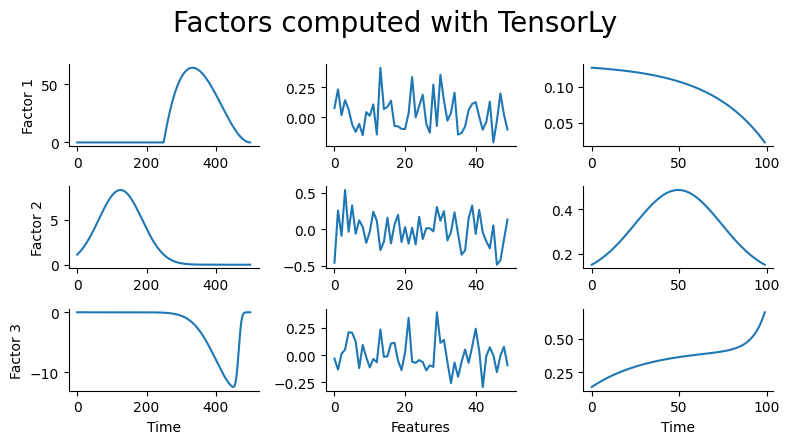

In [ ]:
# plot the decomposed factors from TensorLy
plot_factors(factors_tl[1], d=3)
plt.suptitle("Factors computed with TensorLy", y=1.1, fontsize=20);

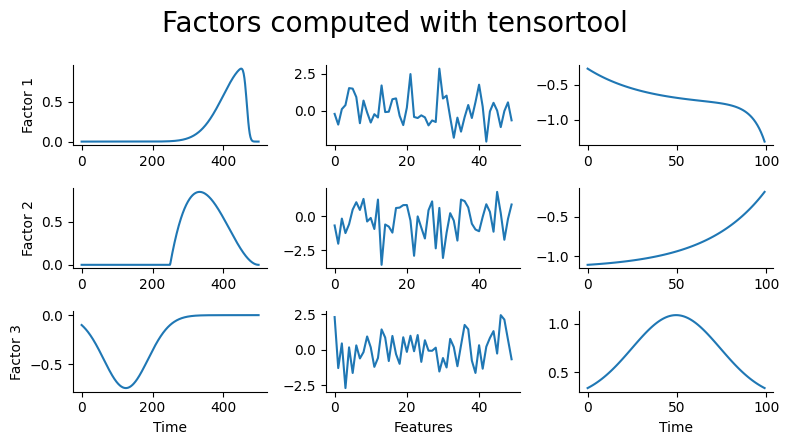

In [ ]:
# plot the decomposed factors from tensortool
plot_factors(factors_tt, d=3)
plt.suptitle("Factors computed with tensortool", y=1.1, fontsize=20);

### Tensor Decomposition using Numpy

Оптимизационная проблема: мы хотим минимизировать разность между $X$ (ground truth) и $M$ (приближение $X$). Функция ошибки - квадратичная ошибка между $X$ и $M$:


$$\underset{A, B, C}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - m_{ijk})^2 = \underset{A, B, C}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} a_{ir} b_{jr} c_{kr})^2$$

$M$ вычисляется через три матрицы $A$, $B$ and $C$, которые мы не знаем. Их можно найти с помощью подбора одной матрицы при фиксировании других. Мы переключаемся между $A$, $B$ and $C$ до сходимости. Постановка задачи для каждой матрицы:

$$\underset{\color{red}{A}}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} \color{red}{a_{ir}} b_{jr} c_{kr})^2 =
\underset{\color{red}{A}}{\operatorname{min}} || X_{(0)} - \color{red}{A}(B \odot C)^T ||_F^2$$

$$\underset{\color{red}{B}}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} a_{ir} \color{red}{b_{jr}} c_{kr})^2 =
\underset{\color{red}{B}}{\operatorname{min}} || X_{(1)} - \color{red}{B}(A \odot C)^T ||_F^2$$

$$\underset{\color{red}{C}}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} a_{ir} b_{jr} \color{red}{c_{kr}})^2 =
\underset{\color{red}{C}}{\operatorname{min}} || X_{(2)} - \color{red}{C}(A \odot B)^T ||_F^2$$

In [ ]:
def decompose_three_way(tensor, rank, max_iter=501, verbose=False):
    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        target_a = tl.unfold(tensor, mode=0).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))

        # optimize b
        input_b = khatri_rao([a.T, c.T])
        target_b = tl.unfold(tensor, mode=1).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))

        # optimize c
        input_c = khatri_rao([a.T, b.T])
        target_c = tl.unfold(tensor, mode=2).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))

        if verbose and epoch % int(max_iter * .2) == 0:
            res_a = np.square(input_a.dot(a) - target_a)
            res_b = np.square(input_b.dot(b) - target_b)
            res_c = np.square(input_c.dot(c) - target_c)
            print("Epoch:", epoch, "| Loss (C):", res_a.mean(), "| Loss (B):", res_b.mean(), "| Loss (C):", res_c.mean())

    return a.T, b.T, c.T

In [ ]:
factors_np = decompose_three_way(X, rank, verbose=True)

Epoch: 0 | Loss (C): 0.2941964833521435 | Loss (B): 0.11741143395309725 | Loss (C): 0.0430707743091607
Epoch: 100 | Loss (C): 2.0490842222957496e-11 | Loss (B): 1.8435460258525616e-11 | Loss (C): 1.8434085705104962e-11
Epoch: 200 | Loss (C): 2.2651426459508852e-20 | Loss (B): 2.0451005601581887e-20 | Loss (C): 2.0449302828842904e-20
Epoch: 300 | Loss (C): 2.951244898678135e-29 | Loss (B): 2.6642953816819036e-29 | Loss (C): 2.6647397475420045e-29
Epoch: 400 | Loss (C): 1.405138546287725e-31 | Loss (B): 1.4681261985560603e-31 | Loss (C): 1.4145866525819999e-31
Epoch: 500 | Loss (C): 1.0936862531485086e-31 | Loss (B): 1.1402496618268503e-31 | Loss (C): 1.18737897957096e-31


In [ ]:
a, b, c = factors_np
factors = (normalize(a), normalize(b), normalize(c))

In [ ]:
# compute M and reconstruction eror
M_np = reconstruct(factors_np)
rec_error_np = np.mean((X-M_np)**2)

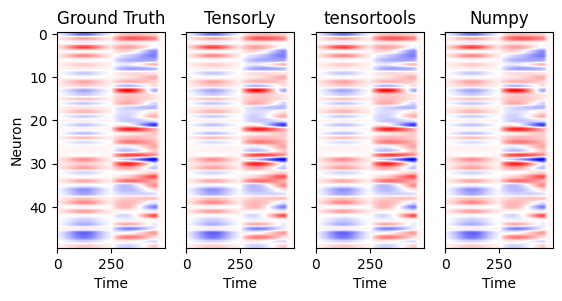

In [ ]:
# comparison between the three approaches on a single trial
fig, axes = plt.subplots(1, 4, sharey=True)
tensors = [X, M_tl, M_tt, M_np]
titles = ["Ground Truth", "TensorLy", "tensortools", "Numpy"]
trial_num = 75

for title, tensor, ax in zip(titles, tensors, axes):
    ax.imshow(tensor[:, :, trial_num].T, cmap='bwr', aspect=20)
    ax.set_xlabel("Time")
    ax.set_title(title)
axes[0].set_ylabel("Neuron");

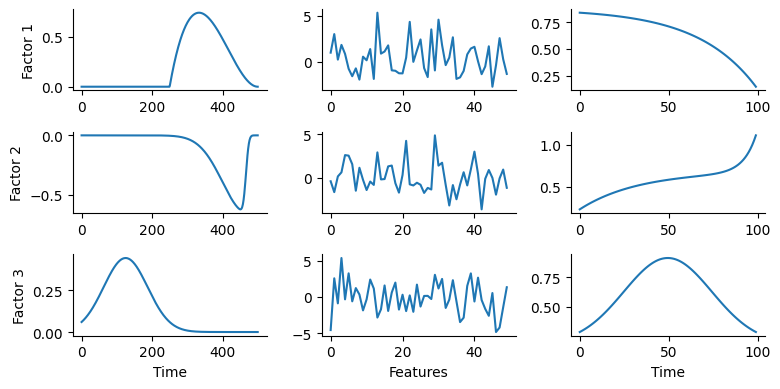

In [ ]:
plot_factors(factors_np, d=3)

In [ ]:
factors = (normalize(a), normalize(b), normalize(c))

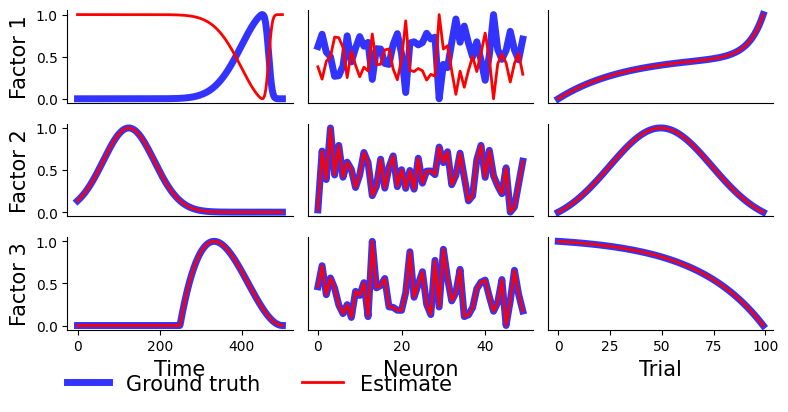

In [ ]:
# compare estimate with ground truth
fig, axes = plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
compare_factors(factors, factors_actual, factors_ind=[1, 2, 0], fig=fig);

### Reconstruction error and time comparison

In [ ]:
import timeit

In [ ]:
iter_num = 50
times = {'tl': [], 'tt': [], 'np': []}
rec_errors = {'tl': [], 'tt': [], 'np': []}

# TensorLy
for i in range(iter_num):
    start_time = timeit.default_timer()
    factors_tl = parafac(X, rank=rank, tol=0, n_iter_max=200)
    end_time = timeit.default_timer() - start_time
    times['tl'].append(end_time)
    M_tl = reconstruct(factors_tl[1])
    rec_error_tl = np.mean((X-M_tl)**2)
    rec_errors['tl'].append(rec_error_tl)
    print("TensorLy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time), end="\r")

# Tensortools
for i in range(iter_num):
    start_time = timeit.default_timer()
    U = tt.cp_als(X, rank=rank, tol=0, max_iter=200, verbose=False)
    factors_tt = U.factors.factors
    end_time = timeit.default_timer() - start_time
    times['tt'].append(end_time)
    M_tt = reconstruct(factors_tt)
    rec_error_tt = np.mean((X-M_tt)**2)
    rec_errors['tt'].append(rec_error_tt)
    print("tensortools | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time), end="\r")

# Numpy
for i in range(iter_num):
    start_time = timeit.default_timer()
    factors_np = decompose_three_way(X, rank, max_iter=200, verbose=False)
    end_time = timeit.default_timer() - start_time
    times['np'].append(end_time)
    M_np = reconstruct(factors_np)
    rec_error_np = np.mean((X-M_np)**2)
    rec_errors['np'].append(rec_error_np)
    print("Numpy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time),end="\r")

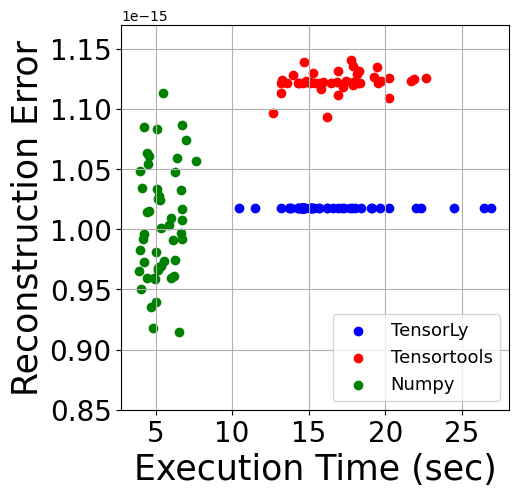

In [50]:
plt.figure(figsize=(5, 5))
factor = 1e15
plt.scatter(np.array(times['tl']), np.array(rec_errors['tl']), c='blue', label="TensorLy")
plt.scatter(np.array(times['tt']), np.array(rec_errors['tt']), c='red', label="Tensortools")
plt.scatter(np.array(times['np']), np.array(rec_errors['np']), c='green', label="Numpy")
plt.xlabel("Execution Time (sec)", fontsize=25)
plt.ylabel("Reconstruction Error", fontsize=25)
plt.ylim(0.85 * 1e-15, 1.17 * 1e-15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower right", fontsize=13)
plt.grid()